## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [5]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [6]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [7]:
num_unique = df.user_id.nunique()
num_unique

290584

d. The proportion of users converted.

In [8]:
num_converted = df.query("converted == 1").count()[0]
num_converted

35237

In [9]:
num_converted/num_unique

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [10]:
df.query("group == 'treatment' and landing_page != 'new_page'").count()[0] + df.query("group != 'treatment' and landing_page == 'new_page'").count()[0]

3893

f. Do any of the rows have missing values?

In [11]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [12]:
df2_1 = df.query("group == 'treatment' and landing_page == 'new_page'")
df2_2 = df.query("group == 'control' and landing_page == 'old_page'")
df2 = df2_1.append(df2_2)


In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [14]:
num_unique2 = df2.user_id.nunique()
num_unique2

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
dup = df2['user_id'].duplicated()
df2[dup]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [16]:
dup = df2['user_id'].duplicated()
df2[dup]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
df2['user_id'].drop_duplicates(inplace=True)

In [18]:
df2['user_id'].duplicated().sum()

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [20]:
df2.query("converted == 1").count()[0]/df2.shape[0]


0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
df2.query("group == 'control' and converted == 1").count()[0]/df2.query("group == 'control'").count()[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
df2.query("group == 'treatment' and converted == 1").count()[0]/df2.query("group == 'treatment'").count()[0]

0.11880724790277405

d. What is the probability that an individual received the new page?

In [21]:
df2.query("landing_page == 'new_page'").count()[0]/df2.shape[0]

0.5000636646764286

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Your answer goes here.**

##### No

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

Null - Old page performs better - Pold >= Pnew
<br>
Hypothesis - New page performs better - Pold < Pnew

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [24]:
new_df = df2.query('landing_page == "new_page"')

In [25]:
new_convert = df2.query('converted == 1').user_id.count()/df2.shape[0]
new_convert

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [26]:
old_df = df2.query('landing_page == "old_page"')

In [105]:
old_convert = df2.converted.mean()
old_convert

0.11959667567149027

c. What is $n_{new}$?

In [29]:
n_new = new_df.count()[0]
n_new

145311

d. What is $n_{old}$?

In [30]:
n_old = old_df.count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [52]:
new_page_converted = np.random.binomial(1,new_convert,n_new).mean()
new_page_converted

0.12033500560866005

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [53]:
old_page_converted = np.random.binomial(1,old_convert,n_old).mean()
old_page_converted

0.11928493742858323

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [118]:
obs_diff = new_page_converted - old_page_converted
obs_diff

0.0010500681800768158

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [112]:
p_diffs = []
for _ in range(10000):
    sample_new_convert = np.random.binomial(1,new_convert,n_new).mean()
    sample_old_convert = np.random.binomial(1,old_convert,n_old).mean()
    p_diffs.append(sample_new_convert - sample_old_convert)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([    4.,    59.,   280.,  1042.,  2280.,  2936.,  2232.,   896.,
          230.,    41.]),
 array([-0.00502062, -0.004099  , -0.00317738, -0.00225576, -0.00133414,
        -0.00041252,  0.0005091 ,  0.00143072,  0.00235233,  0.00327395,
         0.00419557]),
 <a list of 10 Patch objects>)

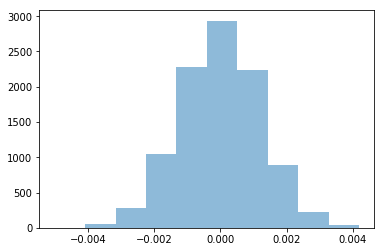

In [114]:
plt.hist(p_diffs, alpha = 0.5)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [115]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0,p_diffs.std(),p_diffs.size)

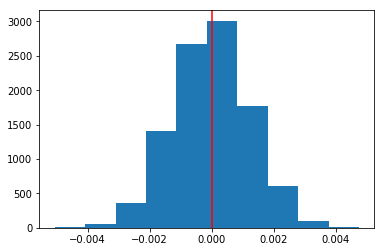

In [116]:
plt.hist(null_vals);
plt.axvline(x = 0, color = 'red');

In [119]:
(obs_diff > null_vals).mean()

0.80189999999999995

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

With a p-value of 0.05, it seems very likely that our statistics is from this null

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [77]:
import statsmodels.api as sm

convert_old = old_convert
convert_new = new_convert
num_old = n_old
num_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [78]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [num_old, num_new])
z_score, p_value

(6.2273498652281703e-05, 0.99995031293691028)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

z-score is around 6.2273 and p-value is around 0.99. 
<br>
The p-value should be the same with the value calculated earlier.
(Not sure what drives the difference between these two values, would you please help?)

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

Logistic Regression should be the appropriate method.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [125]:
df2.head()

,user_id,timestamp,group,landing_page,converted,1,0,treatment,control
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,0


In [157]:
df2[['treatment','control']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,1,0,treatment,control,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,0,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,0,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [158]:
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'],df2[['intercept','treatment','control']])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [129]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Jan 2019   Pseudo R-squ.:               8.085e-06
Time:                        17:50:15   Log-Likelihood:            -1.0639e+05
converged:                      False   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3309   1.36e+05  -9.82e-06      1.000   -2.66e+05    2.66e+05
treatment     -0.6729   1.36e+05  -4.97e-06      1.000   -2.66e+05    2.66e+05
control       -0.6579   1.36e+05  -4.85e-06      1.000   -2.66e+05    2.66e+05
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

p value is 1

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

Since the model doesn't indicate that there's significant relationship between the conversion rate and groups, might be helpful to bring other factors, but bringing other factors might make the model more confusing.
<br>
confusion matrix might indicate some exceptions.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [131]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [139]:
df3 = df2.set_index('user_id').join(df_country.set_index('user_id'))
df3.head()

,timestamp,group,landing_page,converted,1,0,treatment,control,intercept,country
user_id,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,0,1,US
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,0,1,US
630002,2017-01-19 19:20:56.438330,control,old_page,0,0,1,0,1,1,US
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,0,1,US
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,0,1,US


In [146]:
df3.country.unique()

array(['US', 'UK', 'CA'], dtype=object)

In [151]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,timestamp,group,landing_page,converted,1,0,treatment,control,intercept,country,US,UK,CA
user_id,,,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,0,1,US,1,0,0
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,0,1,US,1,0,0
630002,2017-01-19 19:20:56.438330,control,old_page,0,0,1,0,1,1,US,1,0,0
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,0,1,US,1,0,0
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,0,1,US,1,0,0


In [152]:
df3['intercept'] = 1
log_mod2 = sm.Logit(df3['converted'],df3[['intercept','US','UK']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        18:54:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

Country has an impact on the conversion rate. CA is the baseline category. Conversion rate of US is predicted to be 0.05 higher than conversion rate of CA, while conversion rate of UK is 0.04 higher than conversion rate of CA

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [156]:
df3.head()

,timestamp,group,landing_page,converted,1,0,treatment,control,intercept,country,US,UK,CA
user_id,,,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,0,1,US,1,0,0
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,0,1,US,1,0,0
630002,2017-01-19 19:20:56.438330,control,old_page,0,0,1,0,1,1,US,1,0,0
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,0,1,US,1,0,0
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,0,1,US,1,0,0


In [160]:
df3[['new_page','old_page']] = pd.get_dummies(df3['landing_page'])
df3.head()

,timestamp,group,landing_page,converted,1,0,treatment,control,intercept,country,US,UK,CA,new_page,old_page
user_id,,,,,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,0,1,US,1,0,0,1,0
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,0,1,US,1,0,0,1,0
630002,2017-01-19 19:20:56.438330,control,old_page,0,0,1,0,1,1,US,1,0,0,0,1
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,0,1,US,1,0,0,1,0
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,0,1,US,1,0,0,1,0


In [162]:
df3['intercept'] = 1
log_mod3 = sm.Logit(df3['converted'],df3[['intercept','US','UK','new_page','old_page']])
results3 = log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 7


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Fri, 18 Jan 2019   Pseudo R-squ.:               2.324e-05
Time:                        19:03:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3583        nan        nan        nan         nan         nan
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
new_page      -0.6866        nan        nan        nan         nan         nan
old_page      -0.6717        nan        nan        nan         nan         nan
==============================================================================
"""